## Downloading Data (kaggle)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls -lha kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

In [ ]:
!unzip rsna-bone-age.zip

## Downloading Data (Google Drive)

In [ ]:
# Unzip training set file
!unzip /content/drive/MyDrive/boneage_images/boneage_training_set.zip

# Metadata Preparation, Preliminary EDA

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')

df_train.head()
df_val.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


,Image ID,male,Bone Age (months)
0,1386,False,30
1,1392,True,162
2,1397,False,18
3,1401,False,132
4,1410,True,57


In [3]:
# Clean train dataframe
df_train['filename'] = df_train['id'].apply(lambda x: str(x) + '.png')
df_train['gender'] = df_train['male'].apply(lambda x: 'male' if x else 'female')
df_train.drop(columns='male', inplace=True)
df_train.head()

,id,boneage,filename,gender
0,1377,180,1377.png,female
1,1378,12,1378.png,female
2,1379,94,1379.png,female
3,1380,120,1380.png,male
4,1381,82,1381.png,female


In [4]:
# Clean validation dataframe
df_val['filename'] = df_val['Image ID'].apply(lambda x: str(x) + '.png')
df_val['gender'] = df_val['male'].apply(lambda x: 'male' if x else 'female')
df_val.rename(columns={'Image ID': 'id', 'Bone Age (months)': 'boneage'}, inplace=True)
df_val.drop(columns='male', inplace=True)
df_val.head()

,id,boneage,filename,gender
0,1386,30,1386.png,female
1,1392,162,1392.png,male
2,1397,18,1397.png,female
3,1401,132,1401.png,female
4,1410,57,1410.png,male


In [5]:
# Explore datasets
df_train.info()
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12611 entries, 0 to 12610
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        12611 non-null  int64 
 1   boneage   12611 non-null  int64 
 2   filename  12611 non-null  object
 3   gender    12611 non-null  object
dtypes: int64(2), object(2)
memory usage: 394.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1425 non-null   int64 
 1   boneage   1425 non-null   int64 
 2   filename  1425 non-null   object
 3   gender    1425 non-null   object
dtypes: int64(2), object(2)
memory usage: 44.7+ KB


In [6]:
# Explore variables
df_train['boneage'].describe()

count    12611.000000
mean       127.320752
std         41.182021
min          1.000000
25%         96.000000
50%        132.000000
75%        156.000000
max        228.000000
Name: boneage, dtype: float64

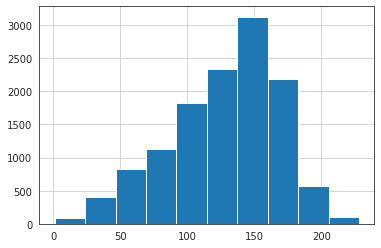

In [7]:
# Look at distribution of bone ages in training set
df_train['boneage'].hist(bins=10);

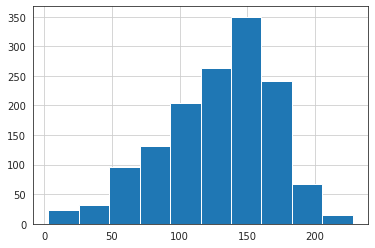

In [8]:
# Look at distribution of bone ages in validation set
df_val['boneage'].hist(bins=10);

The distributions are approximately normal though slightly left-skewed for both datasets. The distributions appear to be similar for both datasets.

In [9]:
# Standardize bone ages
boneage_mean = (df_train['boneage'].mean() + df_val['boneage'].mean()) / 2
boneage_std = (df_train['boneage'].std() + df_val['boneage'].std()) / 2

df_train['boneage_zscore'] = (df_train['boneage'] - boneage_mean)/boneage_std
df_val['boneage_zscore'] = (df_val['boneage'] - boneage_mean)/boneage_std

df_train.head()
df_val.head()

,id,boneage,filename,gender,boneage_zscore
0,1377,180,1377.png,female,1.272830
1,1378,12,1378.png,female,-2.780049
2,1379,94,1379.png,female,-0.801858
3,1380,120,1380.png,male,-0.174627
4,1381,82,1381.png,female,-1.091349


,id,boneage,filename,gender,boneage_zscore
0,1386,30,1386.png,female,-2.345812
1,1392,162,1392.png,male,0.838593
2,1397,18,1397.png,female,-2.635303
3,1401,132,1401.png,female,0.114865
4,1410,57,1410.png,male,-1.694456


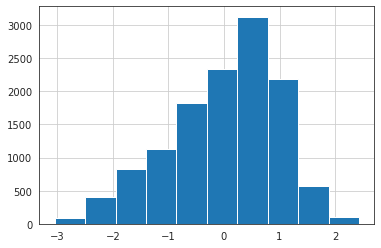

In [10]:
# Look at distribution of bone age z-scores for training set
df_train['boneage_zscore'].hist(bins=10);

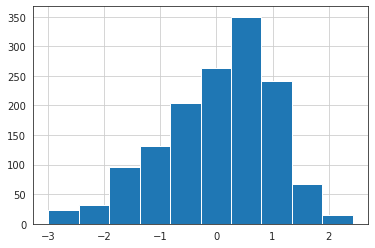

In [11]:
# Look at distribution of bone age z-scores for validation set
df_val['boneage_zscore'].hist(bins=10);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


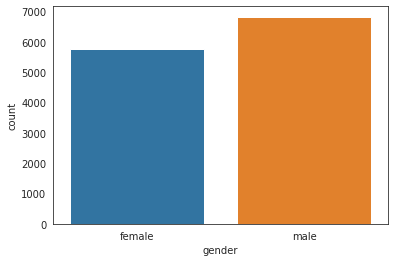

In [12]:
# Look at distribution of genders: training set
sns.countplot(df_train['gender']);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


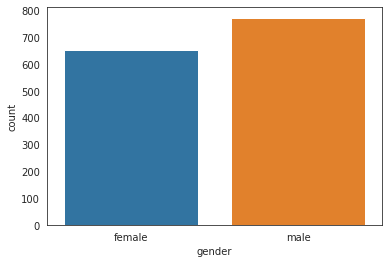

In [13]:
# Look at distribution of genders: validation set
sns.countplot(df_val['gender']);

In [18]:
# Calculate distribution of genders for both datasets
print('TRAINING male %: ', len(df_train[df_train['gender'] == 'male']) / len(df_train) * 100)
print('VALIDATION male %: ', len(df_val[df_val['gender'] == 'male']) / len(df_val) * 100)

TRAINING male %:  54.182856236618825
VALIDATION male %:  54.24561403508772


There are more male images for both datasets and the distribution appears similar between the datasets.

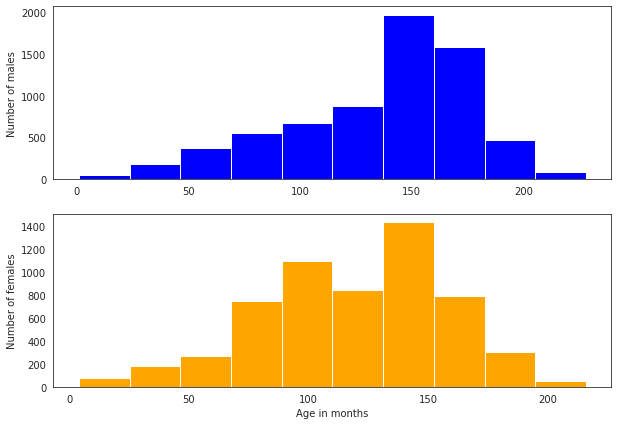

In [15]:
# Look at distribution of ages within each gender: training set
male = df_train[df_train['gender'] == 'male']
female = df_train[df_train['gender'] == 'female']

fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue', bins=10)
ax[0].set_ylabel('Number of males')
ax[1].hist(female['boneage'], color = 'orange', bins=10)
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of females')
fig.set_size_inches((10,7));

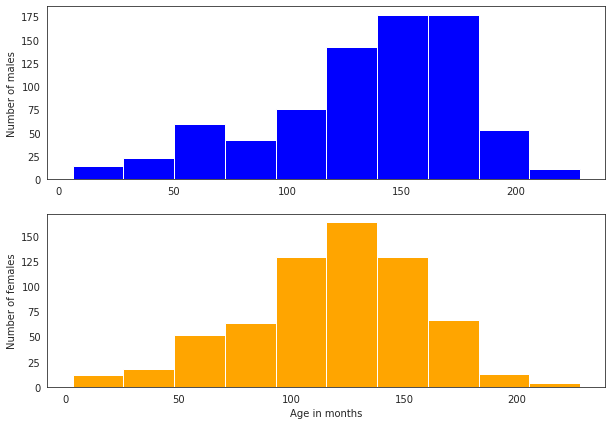

In [16]:
# Look at distribution of ages within each gender: validation set
male = df_val[df_val['gender'] == 'male']
female = df_val[df_val['gender'] == 'female']

fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue', bins=10)
ax[0].set_ylabel('Number of males')
ax[1].hist(female['boneage'], color = 'orange', bins=10)
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of females')
fig.set_size_inches((10,7));

In [ ]:
# Save dataframes as .csv files
df_train.to_csv('df_train.csv', index=False)
df_val.to_csv('df_val.csv', index=False)

In [ ]:
# View some images
from PIL import Image

path = '/content/boneage-training-dataset/'

for filename in train_df['filename'].sample(3):
  img = Image.open(path+filename)
  plt.axis('off')
  plt.imshow(img, cmap='bone')

## Prepare sex-specific datasets

In [25]:
# Training data
df_train_male = df_train[df_train['gender'] == 'male']
df_train_female = df_train[df_train['gender'] == 'female']

# Validation data
df_val_male = df_val[df_val['gender'] == 'male']
df_val_female = df_val[df_val['gender'] == 'female']

In [26]:
# Calculate mean & std for each gender group
male_boneage_mean = (df_train_male['boneage'].mean() + df_val_male['boneage'].mean()) / 2
male_boneage_std = (df_train_male['boneage'].std() + df_val_male['boneage'].std()) / 2

female_boneage_mean = (df_train_female['boneage'].mean() + df_val_female['boneage'].mean()) / 2
female_boneage_std = (df_train_female['boneage'].std() + df_val_female['boneage'].std()) / 2

In [27]:
# Drop original boneage_zscore columns
df_train_male.drop(columns = 'boneage_zscore', inplace = True)
df_val_male.drop(columns = 'boneage_zscore', inplace = True)
df_train_female.drop(columns = 'boneage_zscore', inplace = True)
df_val_female.drop(columns = 'boneage_zscore', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
# Standardize bone ages for each data set
df_train_male['boneage_zscore'] = (df_train_male['boneage'] - male_boneage_mean)/male_boneage_std
df_val_male['boneage_zscore'] = (df_val_male['boneage'] - male_boneage_mean)/male_boneage_std

df_train_female['boneage_zscore'] = (df_train_female['boneage'] - female_boneage_mean)/female_boneage_std
df_val_female['boneage_zscore'] = (df_val_female['boneage'] - female_boneage_mean)/female_boneage_std

df_train_male.head()
df_val_male.head()

df_train_female.head()
df_val_female.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,id,boneage,filename,gender,boneage_zscore
3,1380,120,1380.png,male,-0.356900
5,1382,138,1382.png,male,0.068268
6,1383,150,1383.png,male,0.351713
7,1384,156,1384.png,male,0.493436
8,1385,36,1385.png,male,-2.341017


,id,boneage,filename,gender,boneage_zscore
1,1392,162,1392.png,male,0.635159
4,1410,57,1410.png,male,-1.844988
5,1413,150,1413.png,male,0.351713
6,1421,24,1421.png,male,-2.624462
8,1450,16,1450.png,male,-2.813426


,id,boneage,filename,gender,boneage_zscore
0,1377,180,1377.png,female,1.618352
1,1378,12,1378.png,female,-2.761113
2,1379,94,1379.png,female,-0.623517
4,1381,82,1381.png,female,-0.936336
10,1388,126,1388.png,female,0.210667


,id,boneage,filename,gender,boneage_zscore
0,1386,30,1386.png,female,-2.291884
2,1397,18,1397.png,female,-2.604703
3,1401,132,1401.png,female,0.367076
7,1449,120,1449.png,female,0.054257
10,1465,39,1465.png,female,-2.057270


In [ ]:
# Save dataframes as .csv files
df_train_male.to_csv('df_train_male.csv', index=False)
df_val_male.to_csv('df_val_male.csv', index=False)

df_train_female.to_csv('df_train_female.csv', index=False)
df_val_female.to_csv('df_val_female.csv', index=False)

### Image Preprocessing

In [ ]:
#@title
# Change working directory to save enhanced images
os.chdir('/content/training_enhanced')

# Enhance contrast
# Code from OpenCV tutorial
path = '/content/boneage-training-dataset/boneage-training-dataset/'
for filename in train_df1['filename']:
  id = filename[:-4]
  img = cv2.imread(path+filename,0)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl1 = clahe.apply(img)
  cv2.imwrite('{}.png'.format(id),cl1)

In [ ]:
# Image enhancement
import cv2

def enhance(path, filename):
    '''Function to enhance contrast of images'''
    img = cv2.imread(path+filename,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(64,64))
    cl1 = clahe.apply(img)
    cv2.imwrite(path+filename,cl1)

filenames = list(df_train['filename'])

for filename in filenames:
    enhance('/content/boneage-training-dataset/boneage-training-dataset/', filename)

In [ ]:
# To increase the robustness of my data set (by adding more data) and prevent overfitting,
# I will use image augmentation for my training set
# Code adapted from: ***
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

# Set image size
img_size = 299

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    samplewise_center = False,
    samplewise_std_normalization = False,
    horizontal_flip = True,
    vertical_flip = False,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest')

# Inference
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  width_shift_range = 0.25,
                                  height_shift_range = 0.25,
                                  horizontal_flip = True)

train_generator = train_datagen.flow_from_dataframe(
  df_train,
  directory = '/content/boneage-training-dataset/boneage-training-dataset/',
  x_col = "filename",
  y_col = "boneage_zscore",
  target_size = (img_size, img_size),
  color_mode = "rgb",
  class_mode = "raw",
  batch_size = 32,
  shuffle = True,
  seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
  df_val,
  directory = '/content/drive/MyDrive/boneage_images/boneage-validation-dataset/',
  x_col = "filename",
  y_col = "boneage_zscore",
  target_size = (img_size, img_size),
  color_mode = "rgb",
  class_mode = "raw",
  batch_size = 256,
  shuffle = False,
  seed = 42
)

Found 12611 validated image filenames.
Found 1425 validated image filenames.


In [ ]:
# Test images
test_generator = test_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/boneage_images/boneage_test_images/',
    target_size = (img_size, img_size),
    color_mode = "rgb",
    class_mode = None,
    shuffle = True,
    seed = 42
)

In [ ]:
# For each gender group
# Male
male_train_generator = train_datagen.flow_from_dataframe(
  df_train_male,
  directory = '/content/boneage-training-dataset/boneage-training-dataset/',
  x_col = "filename",
  y_col = "boneage_zscore",
  target_size = (img_size, img_size),
  color_mode = "rgb",
  class_mode = "raw",
  batch_size = 16,
  shuffle = True,
  seed=42
)

male_validation_generator = val_datagen.flow_from_dataframe(
  df_val_male,
  directory = '/content/drive/MyDrive/boneage_images/boneage-validation-dataset/',
  x_col = "filename",
  y_col = "boneage_zscore",
  target_size = (img_size, img_size),
  color_mode = "rgb",
  class_mode = "raw",
  batch_size = 16,
  shuffle = True,
  seed = 42
)

# Female
female_train_generator = train_datagen.flow_from_dataframe(
  df_train_female,
  directory = '/content/boneage-training-dataset/boneage-training-dataset/',
  x_col = "filename",
  y_col = "boneage_zscore",
  target_size = (img_size, img_size),
  color_mode = "rgb",
  class_mode = "raw",
  batch_size = 16,
  shuffle = True,
  seed = 42
)

female_validation_generator = val_datagen.flow_from_dataframe(
  df_val_female,
  directory = '/content/drive/MyDrive/boneage_images/boneage-validation-dataset/',
  x_col = "filename",
  y_col = "boneage_zscore",
  target_size = (img_size, img_size),
  color_mode = "rgb",
  class_mode = "raw",
  batch_size = 16,
  shuffle = True,
  seed = 42
)

In [ ]:
test_X, test_Y = next(flow_from_dataframe(test_datagen,
                                          df_valid,
                                          path_col = '/content/drive/MyDrive/boneage_images/boneage-validation-dataset/',
                                          y_col = 'boneage_zscore',
                                          target_size = img_size,
                                          color_mode = 'rgb',
                                          batch_size = 1425))

In [ ]:
# Function to plot training & validation error
# Code adapted from: ***
def plot_it(history):
    '''Function to plot training and validation error'''
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(history.history['mae_months'])
    ax.plot(history.history['val_mae_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [ ]:
# Functions to calculate mean absolute error
# Code adapted from: ***
from keras.metrics import mean_absolute_error

def mae_months(x_p, y_p):
    return mean_absolute_error((boneage_std*x_p + boneage_mean), (boneage_std*y_p + boneage_mean))

# def mae_months_male(x_p, y_p):
#     return mean_absolute_error((male_boneage_std*x_p + male_boneage_mean), (male_boneage_std*y_p + male_boneage_mean))

# def mae_months_female(x_p, y_p):
#     return mean_absolute_error((female_boneage_std*x_p + female_boneage_mean), (female_boneage_std*y_p + female_boneage_mean)) 

In [ ]:
# Xception model
from tensorflow.keras import Sequential, models, layers, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Flatten, Dropout, Conv2D
from keras.applications.xception import Xception
from keras.optimizers import Adam

# Instantiate convolutional base
conv_base = tf.keras.applications.xception.Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = (299, 299, 3)
)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# Other model(s)
from tensorflow.keras import Sequential, models, layers, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Flatten, Dropout, Conv2D
from keras.applications.resnet_v2 import ResNet50V2

conv_base = tf.keras.applications.ResNet50V2(
    include_top = False,
    weights = "imagenet",
    input_shape = (256, 256, 3)
)

In [ ]:
# Fine-tuning Xception model: unfreeze last 2 blocks
for i, layer in enumerate(conv_base.layers):
    if i < 115:
        layer.trainable = False
    else:
        layer.trainable = True

conv_base.summary()

In [ ]:
# Fine-tuning ResNet50V2 model: unfreeze top 2 layers
for layer in conv_base.layers[:172]:
   layer.trainable = False
for layer in conv_base.layers[172:]:
   layer.trainable = True

conv_base.summary()

In [ ]:
#@title
## Fine-tuning
# Unfreeze last 2 blocks
import re

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if re.search('block14', layer.name):
        set_trainable = True
    if re.search('block13', layer.name):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

In [ ]:
#@title
## Fine-tuning
# Unfreeze last 3 blocks
import re

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if re.search('block14', layer.name):
        set_trainable = True
    if re.search('block13', layer.name):
        set_trainable = True
    if re.search('block12', layer.name):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

In [ ]:
#@title
# Freeze batch normalization layers for training end-to-end
import re

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if not re.search('batch_normalization', layer.name):
    set_trainable = True
  elif set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

conv_base.summary()

In [ ]:
# Build model
model = models.Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(layers.Dense(500, activation='tanh'))
model.add(Dropout(0.25))
model.add(layers.Dense(1, activation='linear'))

# Compile model
model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=[mae_months])

# Look at model
model.summary()

In [ ]:
# Build model: MALE
model_male = models.Sequential()
model_male.add(conv_base)
model_male.add(GlobalAveragePooling2D())
model_male.add(Dropout(0.5))
model_male.add(Flatten())
model_male.add(layers.Dense(500, activation='tanh'))
model_male.add(Dropout(0.25))
model_male.add(layers.Dense(1, activation='linear'))

# Compile model
model_male.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=[mae_months_male])

# Look at model
model_male.summary()

In [ ]:
# Build model: FEMALE
model_female = models.Sequential()
model_female.add(conv_base)
model_female.add(GlobalAveragePooling2D())
model_female.add(Dropout(0.5))
model_female.add(Flatten())
model_female.add(layers.Dense(500, activation='tanh'))
model_female.add(Dropout(0.25))
model_female.add(layers.Dense(1, activation='linear'))

# Compile model
model_female.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=[mae_months_male])

# Look at model
model_female.summary()

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=0,
                               mode='auto')

# Model checkpoint
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_loss',
                     mode='min',
                     save_best_only=True)

# Reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=10,
                                verbose=0,
                                mode='auto',
                                cooldown=5,
                                min_lr=0)

callbacks = [early_stopping,
             mc,
             red_lr_plat]

In [ ]:
# Set up 'no_attn' model
from keras.models import load_model

model = load_model('no_attn_model.h5', custom_objects={'mae_months': mae_months})

# Check its architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [ ]:
# Continue training model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 15,
                    callbacks = callbacks)

In [ ]:
model.save("/content/drive/MyDrive/model")

In [ ]:
# Train model: InceptionV3 model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    callbacks = callbacks)

In [ ]:
# Plot
def plot_history(history, metric):
  mae = history.history['mae_months']
  val_mae = history.history['val_mae_months']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, mae, 'bo', label='Training MAE')
  plt.plot(epochs, val_mae, 'r', label='Validation MAE')
  plt.title('Training and validation MAE')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
# Train model - FEMALE
history_female = model_female.fit(female_train_generator,
                    validation_data = female_validation_generator,
                    epochs = 10,
                    callbacks = callbacks)

## Transfer Learning + Attention Model

In [ ]:
from keras.applications.xception import Xception as PTModel
from tensorflow.keras import Sequential, models, layers
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D,\
Lambda, ActivityRegularization, BatchNormalization, AvgPool2D, MaxPool2D
from keras.models import Model

base_pretrained_model = PTModel(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

pt_features = Input(base_pretrained_model.layers[-1].get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.layers[-1].get_output_shape_at(0)[-1]
bn_features = BatchNormalization()(pt_features)

In [ ]:
#@title
# Attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = MaxPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)

# Branch it to all channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)
mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# To account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps)
attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')
attn_model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_months])    
print('Summary of Attention model only: ')
print(attn_model.summary())

In [ ]:
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'tanh')(attn_layer)

# Fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# To account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1000, activation = 'tanh')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps)
boneage_model = Model(inputs = [pt_features], outputs = [out_layer])
boneage_model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_months])    
print('Summary of Attention model only: ')
print(boneage_model.summary())

In [ ]:
# Combined model
model_combined = Sequential()
model_combined.add(base_pretrained_model)
model_combined.add(boneage_model)
model_combined.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_months])
print("Summary of final model: ")
print(model_combined.summary())

In [ ]:
# Combined model with re-training
history_combined = model_combined.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 15,
                    callbacks = callbacks)

In [ ]:
# Male only
history_combined_male = model_combined.fit(male_train_generator,
                    validation_data = male_validation_generator,
                    epochs = 15,
                    callbacks = callbacks)

In [ ]:
# Female only
history_combined_female = model_combined.fit(female_train_generator,
                    validation_data = female_validation_generator,
                    epochs = 15,
                    callbacks = callbacks)

### Look at attention map

In [ ]:
for attn_layer in model_combined.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape) == 4:
        if c_shape[-1] == 1:
            print(attn_layer)
            break

In [ ]:
import keras.backend as K

rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [bone_age_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_age = boneage_div*test_Y[c_idx]+boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age/12))
    pred_age = boneage_div*bone_age_model.predict(cur_img)+boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age/12))

# fig.savefig('attention_map.png', dpi = 300)

# Predictions

In [ ]:
# Load model
import tensorflow as tf
import keras
from keras import models

saved_model = tf.keras.models.load_model('model_dense.h5', custom_objects={'mae_months': mae_months})

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

img_size = 256

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  width_shift_range=0.25,
                                  height_shift_range=0.25,
                                  horizontal_flip=True)

In [ ]:
test_X, test_Y = next(test_datagen.flow_from_dataframe( 
                            df_val, 
                            directory = '/content/boneage-validation-dataset-1/',
                            x_col = 'filename',
                            y_col = 'boneage', 
                            target_size = (img_size, img_size),
                            # batch_size = 2523,
                            class_mode = 'raw'
                            ))

In [ ]:
# Make predictions
pred = boneage_mean + boneage_std*(model.predict(test_X, batch_size = 32, verbose = True))
# test_months = boneage_mean + boneage_std*(test_Y)
test_months = test_Y

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
# fig.savefig('trained_image_predictions.png', dpi = 300)